In [14]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp, Pauli
from qiskit.primitives import Estimator
from qiskit.circuit import Parameter, ParameterVector
import networkx as nx
import numpy as np
from scipy.optimize import minimize

# Generate the Hamiltonian for a specified g and number of qubits
def hamiltonian_sparse_pauli(g, num_qubits):
    pauli_terms = []
    coefficients = []

    # Add ZZ interaction terms for nearest neighbors with periodic boundary conditions
    #for i in range(num_qubits):  # Include the last pair (last qubit and first qubit)
        #label = ["I"] * num_qubits
        #label[i] = "Z"
        #label[(i + 1) % num_qubits] = "Z"  # Use modulo to wrap around for periodic boundary
        #pauli_terms.append(Pauli("".join(label)))
        #coefficients.append(-1)
        
    # Add ZZ interaction terms for nearest neighbors
    for i in range(num_qubits - 1):  # Exclude the last pair if no boundary conditions
        label = ["I"] * num_qubits
        label[i] = "Z"
        label[i + 1] = "Z"
        pauli_terms.append(Pauli("".join(label)))
        coefficients.append(-1)

    # Add transverse field X terms with coefficient -g
    for i in range(num_qubits):
        label = ["I"] * num_qubits
        label[i] = "X"
        pauli_terms.append(Pauli("".join(label)))
        coefficients.append(-g)

    # Create the Hamiltonian as a SparsePauliOp
    H = SparsePauliOp(pauli_terms, coefficients)
    return H

# Define the QAOA ansatz
def qaoa_ansatz(num_qubits, p):
    graph = nx.complete_graph(num_qubits)  # Complete graph for all-to-all connections
    qc = QuantumCircuit(num_qubits)

    # Create parameters for the ansatz
    beta = [Parameter(f'β{i}') for i in range(p)]  # Mixer angles
    gamma = [Parameter(f'γ{i}') for i in range(p)]  # Cost angles

    # Initial state: |+> state on all qubits
    qc.h(range(num_qubits))

    # QAOA layers
    for i in range(p):
        # Apply the cost Hamiltonian (based on graph edges)
        for u, v in graph.edges:
            qc.rzz(2 * gamma[i], u, v)
        
        # Apply the mixer Hamiltonian (X rotations)
        qc.rx(2 * beta[i], range(num_qubits))

    return qc, beta + gamma

# Define the cost function for optimization
def cost_function(params, hamiltonian, num_qubits, p):
    qc, theta = qaoa_ansatz(num_qubits, p)
    param_dict = {theta[i]: params[i] for i in range(len(theta))}
    bound_circuit = qc.assign_parameters(param_dict)
    
    estimator = Estimator()
    result = estimator.run(bound_circuit, [hamiltonian])
    expectation_value = result.result().values[0]
    
    return expectation_value

# Optimization loop to minimize the expectation value
def optimization_loop(hamiltonian, num_qubits, p, optimizer, initial_params):
    def cost(params):
        return cost_function(params, hamiltonian, num_qubits, p)
    
    result = minimize(cost, initial_params, method=optimizer, options={'maxiter': 1000, 'tol': 1e-6})
    return result.fun, result.x

# Set parameters for the Hamiltonian and QAOA ansatz
g = 0.8
num_qubits = 12
p = 1  # Number of QAOA layers
qubit_hamiltonian = hamiltonian_sparse_pauli(g, num_qubits)

# Generate a random initial set of parameters for 2p parameters (p for beta, p for gamma)
initial_params = np.random.uniform(0, 2 * np.pi, 2 * p)
optimizer = 'COBYLA'

# Run the optimization to find the minimum energy
optimal_value, optimal_params = optimization_loop(qubit_hamiltonian, num_qubits, p, optimizer, initial_params)
print(f'Optimal energy: {optimal_value} Hartree')


Optimal energy: -11.64508188137254 Hartree


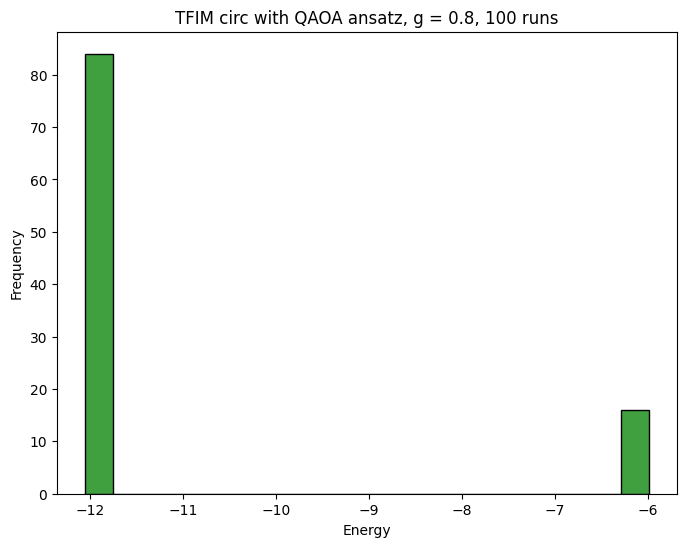

Lowest energy achieved: -12.057660


In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp, Pauli
from qiskit.primitives import Estimator
from qiskit.circuit import Parameter, ParameterVector
import networkx as nx

# Generate the Hamiltonian for a specified g and number of qubits
def hamiltonian_sparse_pauli(g, num_qubits):
    pauli_terms = []
    coefficients = []

    # Add ZZ interaction terms for nearest neighbors
    #for i in range(num_qubits - 1):
        #label = ["I"] * num_qubits
        #label[i] = "Z"
        #label[i + 1] = "Z"
        #pauli_terms.append(Pauli("".join(label)))
        #coefficients.append(-1)

    # Add ZZ interaction terms for nearest neighbors with periodic boundary conditions
    for i in range(num_qubits):  # Include the last pair (last qubit and first qubit)
        label = ["I"] * num_qubits
        label[i] = "Z"
        label[(i + 1) % num_qubits] = "Z"  # Use modulo to wrap around for periodic boundary
        pauli_terms.append(Pauli("".join(label)))
        coefficients.append(-1)   
    # Add transverse field X terms with coefficient -g
    for i in range(num_qubits):
        label = ["I"] * num_qubits
        label[i] = "X"
        pauli_terms.append(Pauli("".join(label)))
        coefficients.append(-g)

    # Create the Hamiltonian as a SparsePauliOp
    H = SparsePauliOp(pauli_terms, coefficients)
    return H

# Define the QAOA ansatz
def qaoa_ansatz(num_qubits, p):
    graph = nx.complete_graph(num_qubits)  # Complete graph for all-to-all connections
    qc = QuantumCircuit(num_qubits)

    # Create parameters for the ansatz
    beta = [Parameter(f'β{i}') for i in range(p)]  # Mixer angles
    gamma = [Parameter(f'γ{i}') for i in range(p)]  # Cost angles

    # Initial state: |+> state on all qubits
    qc.h(range(num_qubits))

    # QAOA layers
    for i in range(p):
        # Apply the cost Hamiltonian (based on graph edges)
        for u, v in graph.edges:
            qc.rzz(2 * gamma[i], u, v)
        
        # Apply the mixer Hamiltonian (X rotations)
        qc.rx(2 * beta[i], range(num_qubits))

    return qc, beta + gamma

# Define the cost function for optimization
def cost_function(params, hamiltonian, num_qubits, p):
    qc, theta = qaoa_ansatz(num_qubits, p)
    param_dict = {theta[i]: params[i] for i in range(len(theta))}
    bound_circuit = qc.assign_parameters(param_dict)
    
    estimator = Estimator()
    result = estimator.run(bound_circuit, [hamiltonian])
    expectation_value = result.result().values[0]
    
    return expectation_value

# Optimization loop to minimize the expectation value
def optimization_loop(hamiltonian, num_qubits, p, optimizer, initial_params):
    def cost(params):
        return cost_function(params, hamiltonian, num_qubits, p)
    
    result = minimize(cost, initial_params, method=optimizer, options={'maxiter': 1000, 'tol': 1e-6})
    return result.fun, result.x

# Function to run optimization multiple times and collect results
def run_multiple_optimizations(num_runs, hamiltonian, num_qubits, p, optimizer):
    energies = []

    for _ in range(num_runs):
        initial_params = np.random.uniform(0, 2 * np.pi, 2 * p)  # Random initial parameters
        optimal_value, optimal_params = optimization_loop(hamiltonian, num_qubits, p, optimizer, initial_params)
        energies.append(optimal_value)

    return energies

# Set parameters for the Hamiltonian and QAOA ansatz
g = 0.8
num_qubits = 12
p = 1  # Number of QAOA layers
qubit_hamiltonian = hamiltonian_sparse_pauli(g, num_qubits)
optimizer = 'COBYLA'
num_runs = 100  # Number of optimization runs

# Run the optimization multiple times and collect the energies
energies = run_multiple_optimizations(num_runs, qubit_hamiltonian, num_qubits, p, optimizer)

# Plot the distribution of energies
plt.figure(figsize=(8, 6))
hist_plot = sns.histplot(energies, kde=False, bins=20, color='green')


# Add title and labels
plt.title('TFIM circ with QAOA ansatz, g = 0.8, 100 runs')
plt.xlabel('Energy')
plt.ylabel('Frequency')

# Show the plot
plt.show()

if energies:
    print(f'Lowest energy achieved: {min(energies):.6f}')
else:
    print("No successful optimizations.")


Exact ground state energy: -14.021144 Hartree


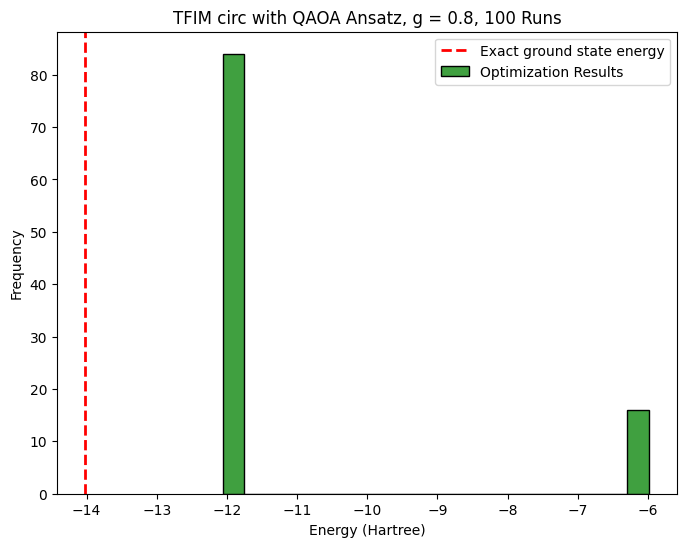

In [17]:
from qiskit_algorithms import NumPyMinimumEigensolver

# Calculate the exact ground state energy
exact_solver = NumPyMinimumEigensolver()
exact_result = exact_solver.compute_minimum_eigenvalue(qubit_hamiltonian)
exact_energy = exact_result.eigenvalue.real
print(f'Exact ground state energy: {exact_energy:.6f} Hartree')

# Re-plot the histogram and overlay the exact energy line
plt.figure(figsize=(8, 6))
sns.histplot(energies, kde=False, bins=20, color='green', label='Optimization Results')

# Add the exact energy line
plt.axvline(exact_energy, color='red', linestyle='--', linewidth=2, label='Exact ground state energy')

# Plot settings
plt.title('TFIM circ with QAOA Ansatz, g = 0.8, 100 Runs')
plt.xlabel('Energy (Hartree)')
plt.ylabel('Frequency')
plt.legend()
plt.draw()